In [114]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
# Define file paths

features_cols = [
    "brand",
    "che_pc_usd",
    "che_perc_gdp",
    "corporation",
    "country",
    "launch_date",
    "ind_launch_date",
    "indication",
    "insurance_perc_che",
    "population",
    "prev_perc",
    "price_month",
    "price_unit",
    "public_perc_che",
    "therapeutic_area"
]
target_col = "target"
id_col = ["date","cluster_nl"]

base_dir = os.path.join(os.path.dirname(os.getcwd()), "dataset")
# Load datasets
# data = pd.read_csv(f"{base_dir}/train_data.csv", usecols=features_cols + [target_col] + id_col)

df = pd.read_csv(f"{base_dir}/train_data.csv", usecols=features_cols + [target_col] + id_col)
print(f"Data loaded: train_data.csv")
print(f"Data shape: {df.shape}")

test_data = pd.read_csv(f"{base_dir}/submission_data.csv", usecols=features_cols + id_col)



Data loaded: train_data.csv
Data shape: (118917, 18)


In [116]:
df.dropna(subset=[target_col], inplace=True)
df['target'] = np.log(df['target'])

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118917 entries, 0 to 118916
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   brand               118917 non-null  object 
 1   che_pc_usd          118917 non-null  float64
 2   che_perc_gdp        118917 non-null  float64
 3   cluster_nl          118917 non-null  object 
 4   corporation         118917 non-null  object 
 5   country             118917 non-null  object 
 6   launch_date         118917 non-null  object 
 7   date                118917 non-null  object 
 8   ind_launch_date     118917 non-null  object 
 9   indication          118917 non-null  object 
 10  insurance_perc_che  118917 non-null  float64
 11  population          118917 non-null  float64
 12  prev_perc           118917 non-null  float64
 13  price_month         118917 non-null  float64
 14  price_unit          118917 non-null  float64
 15  public_perc_che     118917 non-nul

In [118]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date')

print(df['target'])


0         0.000783
1         0.000000
2         0.002256
3         0.066500
4         0.035668
            ...   
118912    0.185365
118913    0.103704
118914    0.295160
118915    0.236518
118916    0.001762
Name: target, Length: 118917, dtype: float64


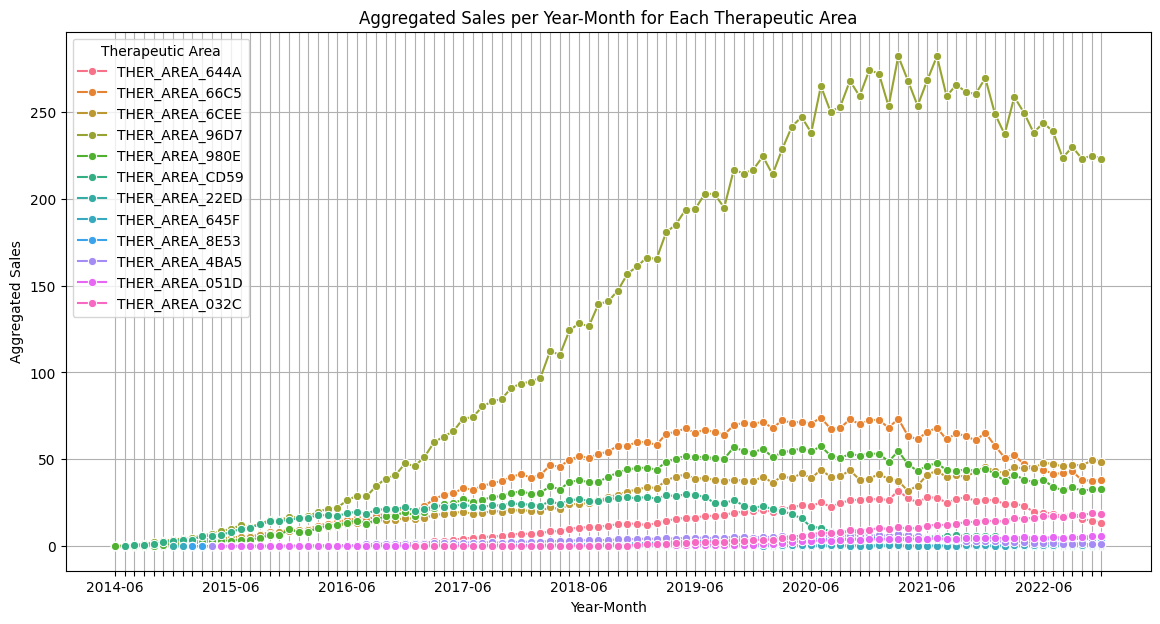

In [119]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['yearmonth'] = df['date'].dt.strftime('%Y-%m')



monthly_sales_therapeutic = df.groupby(['yearmonth', 'therapeutic_area'])['target'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_sales_therapeutic, x='yearmonth', y='target', hue='therapeutic_area', marker='o', sort=True)

plt.title('Aggregated Sales per Year-Month for Each Therapeutic Area')
plt.xlabel('Year-Month')
plt.ylabel('Aggregated Sales')
plt.legend(title='Therapeutic Area')
plt.grid(True)
n = 12  # Show every 6th label
for index, label in enumerate(plt.gca().get_xticklabels()):
    if index % n != 0:
        label.set_visible(False)



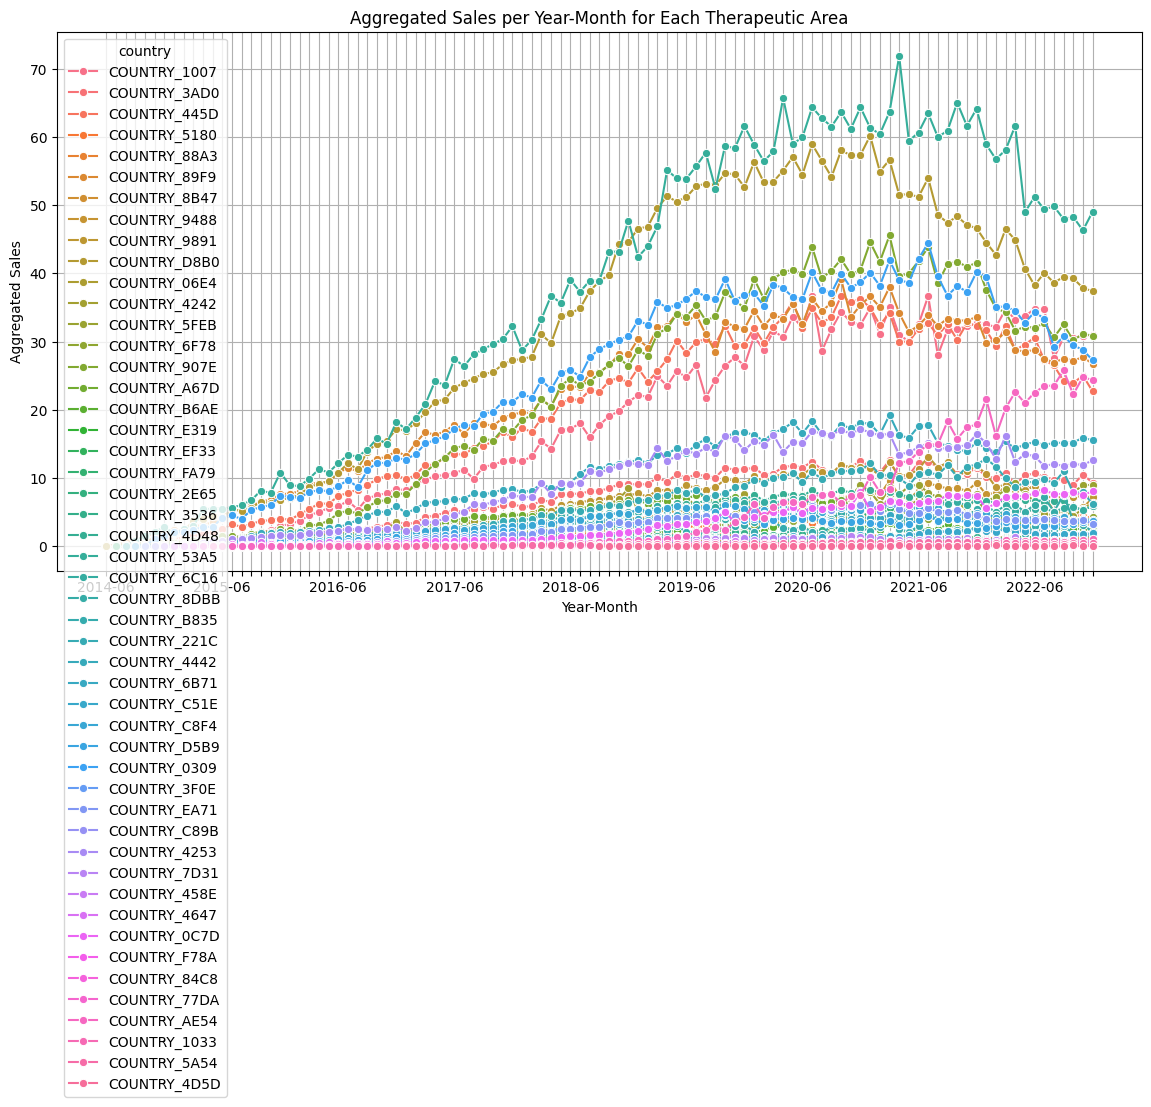

In [120]:
monthly_sales_country = df.groupby(['yearmonth', 'country'])['target'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_sales_country, x='yearmonth', y='target', hue='country', marker='o', sort=True)

plt.title('Aggregated Sales per Year-Month for Each Therapeutic Area')
plt.xlabel('Year-Month')
plt.ylabel('Aggregated Sales')
plt.legend(title='country')
plt.grid(True)
n = 12  # Show every 6th label
for index, label in enumerate(plt.gca().get_xticklabels()):
    if index % n != 0:
        label.set_visible(False)




In [121]:
# One-hot encoding for 'therapeutic_area' and 'cluster_nl'
df = pd.get_dummies(df, columns=['therapeutic_area', 'cluster_nl'], drop_first=True)

# Label encoding for 'country' if there are many categories
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['country_encoded'] = le.fit_transform(df['country'])

# Ensure 'price_month' is numeric
df['price_month'] = pd.to_numeric(df['price_month'], errors='coerce')

# Calculate average price per year
df['avg_price_per_year'] = df['price_month'] * 12


# Interaction between 'prev_perc' and 'avg_price_per_year'
df['prev_perc_x_avg_price'] = df['prev_perc'] * df['avg_price_per_year']

df['indication_number'] = len(df['indication'].unique())

# Interaction between 'indication_number' and 'month_number'
df['indication_x_month'] = df['indication_number'] * df['month']

In [123]:
# Bin 'avg_price_per_year' into quartiles
df['price_bin'] = pd.qcut(df['avg_price_per_year'], q=4, labels=False)

# Mean target by country
country_mean_price = df.groupby('country')['avg_price_per_year'].transform('mean')
df['country_mean_price'] = country_mean_price

In [124]:
# Month as cyclic features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

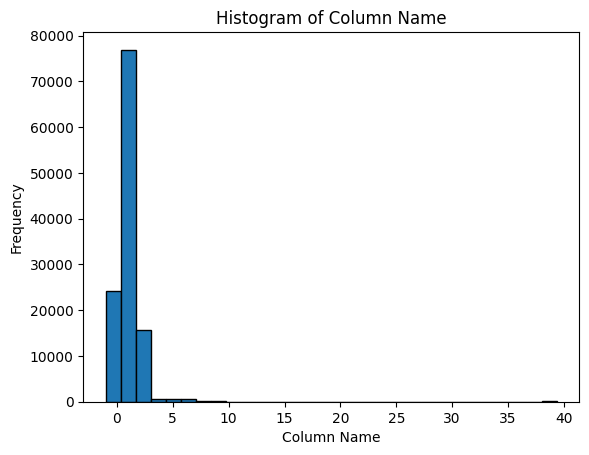

In [135]:
# Price per indication
df['price_per_indication'] = df['avg_price_per_year'] / df['indication_number']

# Log transformation of price
df['log_avg_price'] = np.log1p(df['avg_price_per_year'])

data = df['price_month']

# Plot histogram
plt.hist(data, bins=30, edgecolor='black')

plt.xlabel('Column Name')
plt.ylabel('Frequency')
plt.title('Histogram of Column Name')
plt.show()

In [126]:
from sklearn.cluster import KMeans

# Select features for clustering
clustering_features = df[['prev_perc', 'avg_price_per_year']]

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster_group'] = kmeans.fit_predict(clustering_features)

In [127]:
# If you have 'launch_date' and 'date'
df['launch_date'] = pd.to_datetime(df['launch_date'])
df['days_since_launch'] = (df['date'] - df['launch_date']).dt.days

In [133]:
min_value = df['country_mean_price'].min()

# Filter rows where 'country_mean_price' equals the minimum value
min_rows = df[df['country_mean_price'] == min_value]
print(min_rows)

min_index = df['country_mean_price'].idxmin()

# Display the full row corresponding to the minimum value
min_row = df.loc[min_index]
print(min_row)

print(f"Index of minimum value: {min_index}")
print(df.loc[min_index])

             brand  che_pc_usd  che_perc_gdp corporation       country  \
1       BRAND_626D   -1.000000     -1.000000   CORP_01C7  COUNTRY_8B47   
23      BRAND_626D   -1.000000     -1.000000   CORP_01C7  COUNTRY_8B47   
26      BRAND_626D    1.085830      1.747924   CORP_01C7  COUNTRY_EF33   
43      BRAND_FCEB    1.085830      1.747924   CORP_7E54  COUNTRY_EF33   
58      BRAND_626D   -1.000000     -1.000000   CORP_01C7  COUNTRY_8B47   
...            ...         ...           ...         ...           ...   
118873  BRAND_D72F    1.004518      1.043471   CORP_01C7  COUNTRY_7D31   
118882  BRAND_D786   -1.000000     -1.000000   CORP_01C7  COUNTRY_8B47   
118890  BRAND_3739    1.092886      1.322266   CORP_01C7  COUNTRY_AE54   
118900  BRAND_CCAA    1.092886      1.322266   CORP_8F4F  COUNTRY_AE54   
118907  BRAND_F148   -1.000000     -1.000000   CORP_01C7  COUNTRY_8B47   

       launch_date       date      ind_launch_date                indication  \
1       2014-06-01 2014-06-01  